# How does Quality Control impact our power for genetic-based discovery?

In an ideal world, we don't lose *any* data. However, there are *always* some issues that can occur when performing data collection and experimental errors that can occur that lead to some loss of data. The degree to which data is lost can really make a large difference in the quality of the evidence that we can have to address potential questions downstream. There are several possible types of errors that can occur, for example:

* Individuals may have rescinded their consent for the study 
* Genotyping may have very low-call rate for each variant on an array, or have high contamination
* Some individuals may have been provided an early survey/assay where the current phenotype of interest is not measured, making you have to exclude these samples. 

This notebook is meant to breakdown errors in a way that commonly impact GWAS and other genotype to phenotype mapping strategies. We will focus on these two categories:

* Phenotyping Errors: Any errors that impact phenotype missingness (survey errors, consent, etc ...)
* Genotyping Errors: Any errors that impact our ability to genotype individuals (call rate, duplicated individuals, etc ...)

In the cells below, you can explore how the rates of these types of errors can be valuable when setting expectations of how many samples are actually required. In addition, we provide some brief examples of how to estimate some of the costs that are  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import sys
sys.path.append('../qtl_power/')
from gwas import GwasQuant, GwasBinary

%matplotlib inline

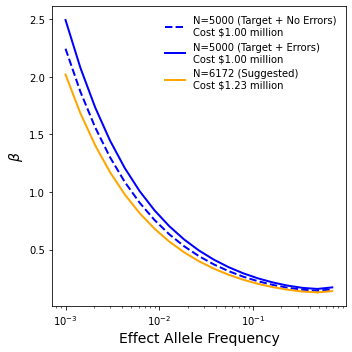

In [2]:
target_sample_size = 5000 # This is the target sample-size for the cohort 

phenotyping_error = 0.1 # This is proportion of individuals x phenotype pairs removed due to phenotyping QC
genotyping_error = 0.1 # This is the proportion of individual x phenotype pairs removed due to genotyping QC

# NOTE: here the assumption is that genotyping and phenotyping errors affect distinct sets of individuals
#  so this is overly conservative ...
real_sample_size = int(target_sample_size*(1.-phenotyping_error)*(1.-genotyping_error))
request_sample_size = int(target_sample_size/((1.-phenotyping_error)*(1.-genotyping_error)))

# Estimating the cost (in million USD) for establishing each cohort
phenotyping_cost = 50 # cost of phenotyping a single individual
genotyping_cost = 150 # cost of genotyping a single individual
cost_target = target_sample_size * (phenotyping_cost + genotyping_cost) / 1e6
cost_requested = request_sample_size * (phenotyping_cost + genotyping_cost) / 1e6

# Parameters to change with regards to the power-calculation ...
r2=0.90 # imputation r2
target_power = 0.9 # discovery power target that we would like to have 
alpha = 5e-8 # genome-wide significant threshold 


# -------- NOTE: Do not edit beyond this if not comfortable! ---------- # 
fig, ax = plt.subplots(1,1,figsize=(5,5))
gwas_power = GwasQuant()
# Setup the grid of minor-allele frequencies
ps = np.logspace(np.log10(1e-3), np.log10(1.0), 20) # 20 points offers decent speed ...

# For each sample-size, find the MAF-beta curve that meets this power demand
# NOTE: lower is always better in this case!
opt_betas = [gwas_power.quant_trait_beta_power(n=target_sample_size, p=p, power=target_power, r2=r2, alpha=alpha) for p in ps]
opt_betas_error = [gwas_power.quant_trait_beta_power(n=real_sample_size, p=p, power=target_power, r2=r2, alpha=alpha) for p in ps]
opt_betas_request = [gwas_power.quant_trait_beta_power(n=request_sample_size, p=p, power=target_power, r2=r2, alpha=alpha) for p in ps]

ax.plot(ps, opt_betas, lw=2, linestyle='--', color='blue', label=f'N={target_sample_size} (Target + No Errors)\nCost \${cost_target:.2f} million')
ax.plot(ps, opt_betas_error, lw=2, color='blue', label=f'N={target_sample_size} (Target + Errors)\nCost \${cost_target:.2f} million')
ax.plot(ps, opt_betas_request, lw=2, color='orange', label=f'N={request_sample_size} (Suggested)\nCost \${cost_requested:.2f} million')
ax.set_xscale('log') # scaling the x-axis by the log of the frequency 
ax.legend(frameon=False)
ax.set_ylabel(r'$\beta$', fontsize=14)
ax.set_xlabel(r'Effect Allele Frequency', fontsize=14)
plt.tight_layout()